# Código Python - Trabalho 2

## *Imports* estáticos

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [10]:
dados = pd.read_csv('../../dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']).rename(columns={"Value":"Premature_Deaths"})
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

#### Sumário dos dados

In [11]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Outcome                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Premature_Deaths              49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB
None


### 4.1.2   Exploração com gráficos

In [12]:
dados.describe()

Affected_Population  Populated_Area[km2]  Air_Pollution_Average[ug/m3]  \
count         4.914000e+04         4.914000e+04                  49140.000000   
mean          1.023692e+06         6.534426e+03                     15.138166   
std           9.085726e+06         5.661679e+04                     22.579360   
min           2.674000e+03         2.000000e+00                      0.100000   
25%           1.069040e+05         5.697000e+02                      7.200000   
50%           2.388280e+05         1.340100e+03                      8.900000   
75%           5.988800e+05         4.215200e+03                     11.400000   
max           4.680626e+08         2.687568e+06                    125.700000   

       Premature_Deaths  
count      49140.000000  
mean         366.798657  
std         5494.481929  
min            0.000000  
25%            3.000000  
50%           23.000000  
75%          112.000000  
max       740933.000000

In [13]:
features = list(dados.columns[0:8])
print(features)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']


In [14]:
numericFeatures = features[4:]
numericFeatures

['Affected_Population',
 'Populated_Area[km2]',
 'Air_Pollution_Average[ug/m3]',
 'Premature_Deaths']

#### Análise Univariável

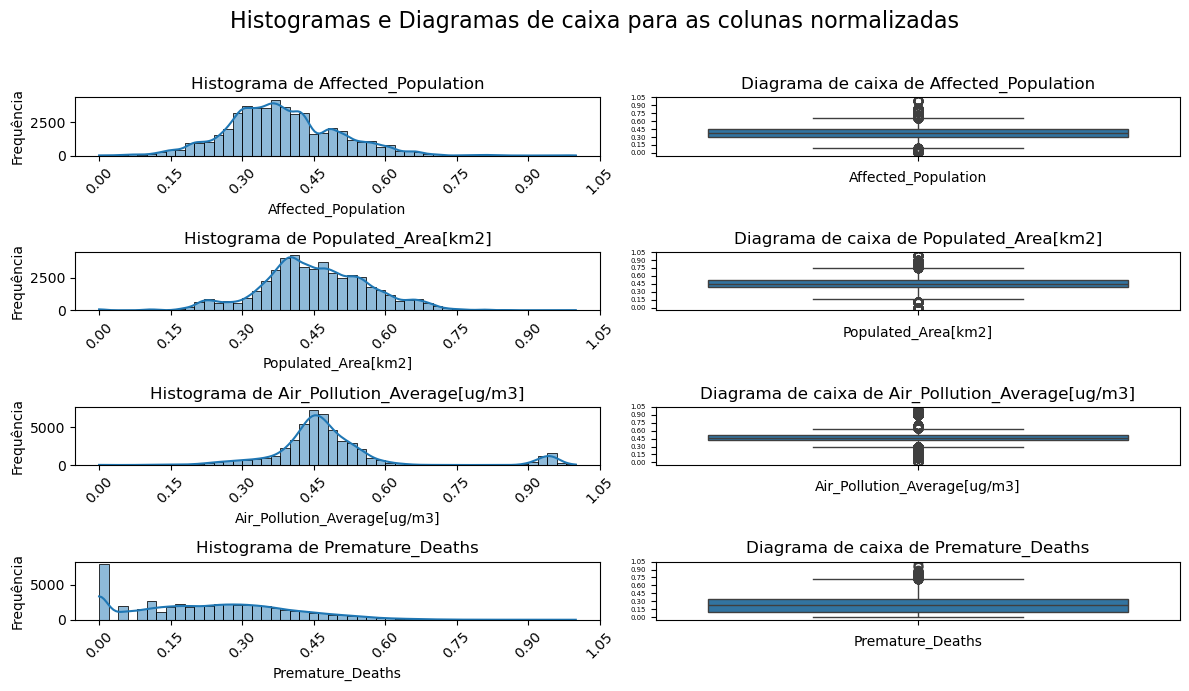

In [15]:
# Aplicar log1p (log(1 + x)) para reduzir o impacto de valores extremos
dados_log = dados[numericFeatures].apply(lambda x: np.log1p(x))

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
dados_scaled = pd.DataFrame(scaler.fit_transform(dados_log), columns=numericFeatures)

num_features = len(numericFeatures)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 3 + num_features))
fig.suptitle("Histogramas e Diagramas de caixa para as colunas normalizadas", fontsize=16)

for i, column in enumerate(numericFeatures):

    sns.histplot(dados_scaled[column], ax=axes[i, 0], kde=True, bins=50)
    axes[i, 0].set_title(f"Histograma de {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequência")
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(10))

    sns.boxplot(y=dados_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Diagrama de caixa de {column}")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis='y', labelsize=5)
    axes[i, 1].yaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Análise Bivariável

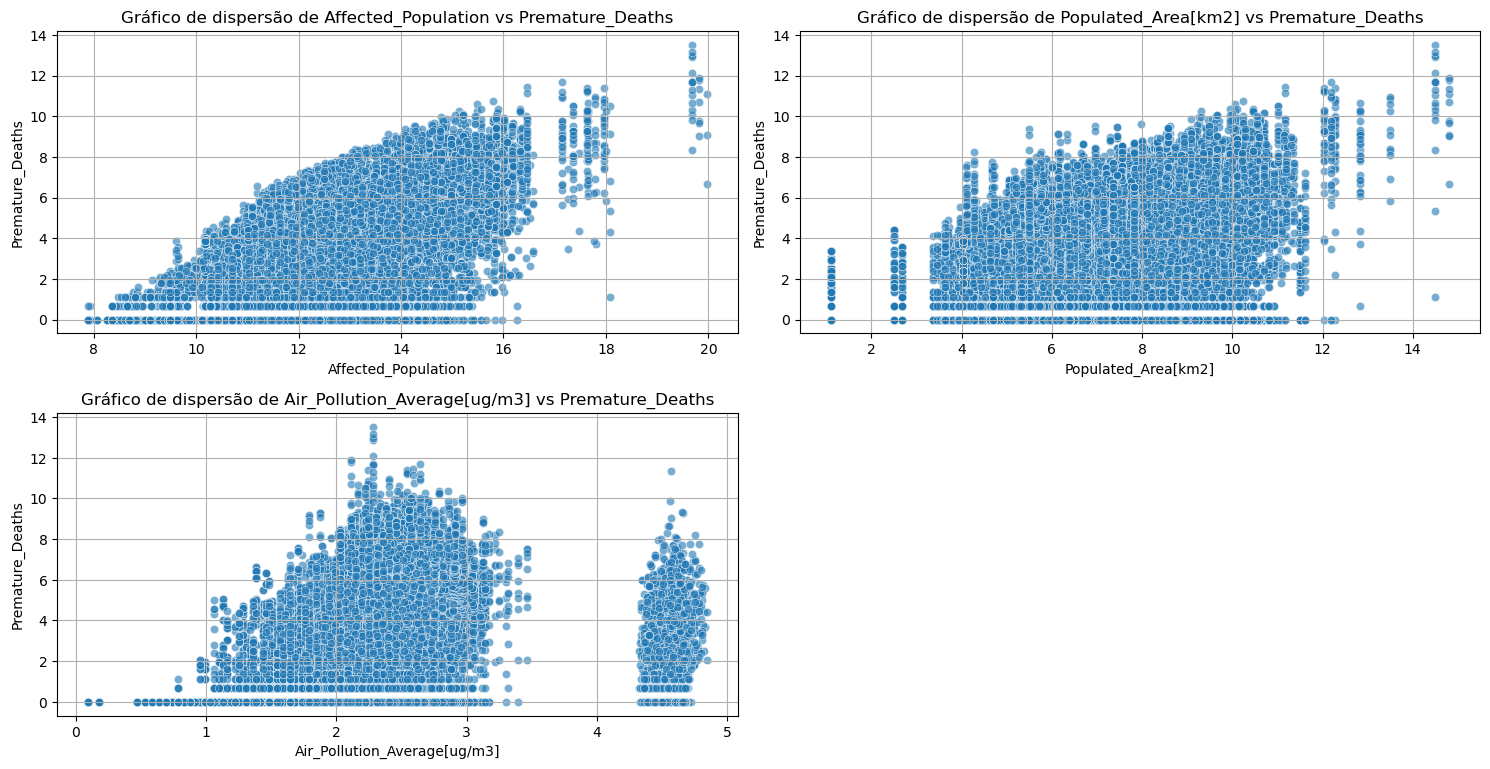

In [16]:
goalAttrib = 'Premature_Deaths'

plt.figure(figsize=(15,15))
numericFeaturesWOValue = [f for f in numericFeatures if f != goalAttrib]
for i, feature in enumerate(numericFeaturesWOValue):
    rows = (len(numericFeaturesWOValue) + 1) # Adjust rows to handle odd number of features
    plt.subplot(rows,2,i+1)
    sns.scatterplot(x=dados_log[feature], y=dados_log[goalAttrib], alpha=0.6)
    plt.title("Gráfico de dispersão de " + feature + " vs " + goalAttrib)
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()
plt.tight_layout()

### 4.1.3. Pré-processamento dos dados

In [17]:
# Remover outliers
print(f"Número de linhas antes da remoção de outliers: {len(dados)}")

for col in numericFeatures:
    Q1 = dados[col].quantile(0.25)
    Q3 = dados[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (dados[col] >= (Q1 - 1.5 * IQR)) & (dados[col] <= (Q3 + 1.5 * IQR))
    dados = dados[filtro]

print(f"Número de linhas após remoção de outliers: {len(dados)}")

Número de linhas antes da remoção de outliers: 49140
Número de linhas após remoção de outliers: 30917


### 4.1.4. Agrupamento dos dados em zonas

In [18]:
westEuDados = dados[dados['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'])]
eastEuDados = dados[dados['Country'].isin(['Poland', 'Czechia', 'Hungary'])]
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
nortEuDados = dados[dados['Country'].isin(['Sweden', 'Denmark', 'Northern Europe', 'Finland'])]

### 4.2.2 - Com o método k-fold cross validation obter um modelo de regressão linear simples para a variável Premature_Deaths usando a variável Affected_Population dos países do Southern Europe

In [19]:
goalAttr = soutEuDados.columns[7]
feature = soutEuDados.columns[4]

print(f"Goal attribute: {goalAttr}")
print(f"Feature: {feature}")


Goal attribute: Premature_Deaths
Feature: Affected_Population


#### Divisão dos dados (Holdout stratied: 80% Train / 20% Test)

In [20]:
from sklearn.model_selection import train_test_split

y = soutEuDados[goalAttr]
X = soutEuDados[feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train set size: ' + str(X_train.shape) + "x_test_size" + str(X_test.shape))
print('Test set size: ' + str(y_train.shape) + "y_test_size" + str(y_test.shape))

Train set size: (4532,)x_test_size(1134,)
Test set size: (4532,)y_test_size(1134,)


#### K-Fold Cross Validation

In [21]:
from sklearn.model_selection import KFold

def split_into_k_folds(data, k):

    kf = KFold(n_splits=k, shuffle=True)

    folds = []
    for train_index, test_index in kf.split(data):
        folds.append((train_index, test_index))
    
    return folds

In [22]:
K=10
kFolds = split_into_k_folds(X_train, K)
for train_idx, test_idx in kFolds:
    print({len(train_idx), len(test_idx)})
    print(train_idx)
    print(test_idx)

{454, 4078}
[   0    1    2 ... 4529 4530 4531]
[   6   11   15   23   29   41   89  104  113  118  130  148  153  160
  164  191  197  200  214  217  227  229  233  250  256  271  276  293
  305  308  320  329  337  338  361  371  385  390  393  418  438  446
  453  456  461  489  502  508  510  513  528  530  531  557  569  573
  577  582  587  602  612  614  617  626  630  646  647  654  668  673
  674  684  694  701  704  711  715  730  732  735  738  739  747  767
  769  786  797  800  802  809  810  811  870  891  894  914  925  929
  936  943  953  963  978  986  997  998  999 1003 1005 1011 1018 1046
 1054 1061 1067 1083 1085 1086 1094 1095 1117 1121 1151 1165 1175 1181
 1195 1203 1218 1225 1230 1246 1250 1261 1265 1271 1276 1295 1296 1301
 1377 1386 1407 1419 1432 1435 1445 1457 1466 1472 1477 1488 1529 1563
 1595 1622 1627 1632 1669 1670 1678 1694 1705 1715 1764 1770 1771 1774
 1789 1802 1824 1834 1852 1865 1868 1877 1916 1922 1937 1942 1956 1973
 1978 1987 2000 2053 2066 207

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

coefs = []
intercepts = []

for train_idx, test_idx in kFolds:
    X_train_fold = X_train.iloc[train_idx].to_frame()
    y_train_fold = y_train.iloc[train_idx]
    lr.fit(X_train_fold, y_train_fold)
    coefs.append(lr.coef_[0])
    intercepts.append(lr.intercept_)

coef_mean = np.mean(coefs)
coef_std = np.std(coefs)
intercept_mean = np.mean(intercepts)
intercept_std = np.std(intercepts)

print(f"Função linear média: {goalAttr} = ({np.round(coef_mean, 6)} ± {np.round(coef_std, 6)}) * {feature} + ({np.round(intercept_mean, 3)} ± {np.round(intercept_std, 3)})")

Função linear média: Premature_Deaths = (5.4e-05 ± 1e-06) * Affected_Population + (16.441 ± 0.214)


#### Visualização da reta e da dispersão dos dados

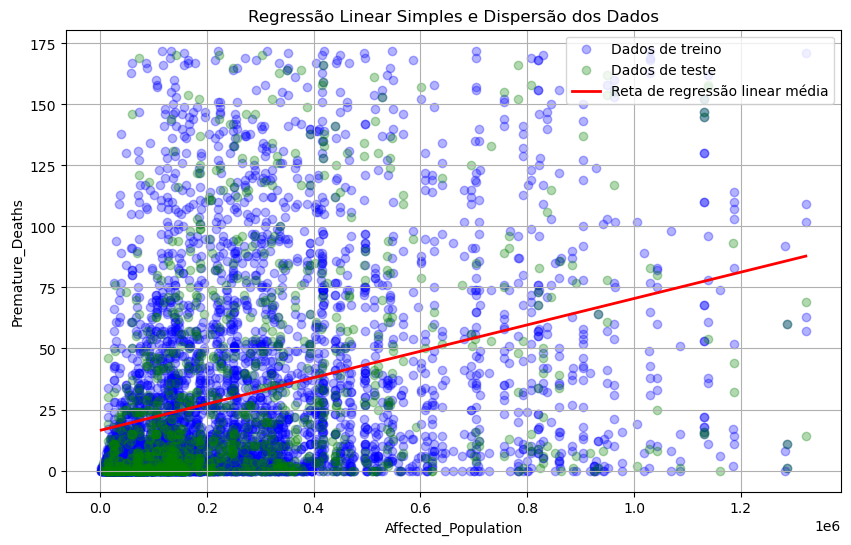

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', alpha=0.3, label='Dados de treino')
plt.scatter(X_test, y_test, color='green', alpha=0.3, label='Dados de teste')
x_vals = np.linspace(X.min(), X.max(), 100)
y_vals = coef_mean * x_vals + intercept_mean
plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Reta de regressão linear média')
plt.xlabel(feature)
plt.ylabel(goalAttr)
plt.title('Regressão Linear Simples e Dispersão dos Dados')
plt.legend()
plt.grid(True)
plt.show()

#### Calcular o MAE e o RMSE

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Previsão nos dados de teste
y_pred_test = coef_mean * X_test + intercept_mean

# Calcular MAE e RMSE
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"MAE: {np.round(mae, 3)}")
print(f"RMSE: {np.round(rmse, 3)}")

MAE: 28.534
RMSE: 38.259
